In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# ----------------------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------------------


# Load datasets
fights = pd.read_csv("ufc_fight_data.csv")
fighters = pd.read_csv("ufc_fighter_stats.csv")

# Remove fights without winners (NC or missing)
fights = fights[fights["winner"].isin(["red", "blue"])].copy()

# Set target: red win = 1, blue win = 0
fights["target"] = fights["winner"].apply(lambda x: 1 if x == "red" else 0)


In [3]:
# ----------------------------------------------------------------------
# CLEAN FIGHT-LEVEL COLUMNS (before merging fighters)
# - Trim names, normalize winner labels
# - Parse `date` to datetime
# - Standardize stances
# - Coerce percent-like and object numeric columns to numeric where appropriate
# ----------------------------------------------------------------------

# Trim whitespace from fighter name fields
for name_col in ["red_name", "blue_name"]:
    if name_col in fights.columns:
        fights[name_col] = fights[name_col].astype(str).str.strip()

# Normalize the winner column to 'red' / 'blue'
if 'winner' in fights.columns:
    fights['winner'] = fights['winner'].astype(str).str.lower().str.strip()
    # common short/alternate encodings -> standard
    fights['winner'] = fights['winner'].replace({
        'r': 'red', 'b': 'blue',
        'red corner': 'red', 'blue corner': 'blue',
        'red/blue': np.nan
    })

# Parse date to datetime when available
if 'date' in fights.columns:
    fights['date'] = pd.to_datetime(fights['date'], errors='coerce')

# Standardize stance strings if present (keep human-readable values)
for s_col in ['red_stance', 'blue_stance']:
    if s_col in fights.columns:
        s = fights[s_col].astype(str).str.lower().str.strip()
        s = s.replace({'nan': np.nan})
        # map common variants to canonical values
        s = s.replace({
            'orth': 'Orthodox', 'orthodox': 'Orthodox',
            'southpaw': 'Southpaw', 'switch': 'Switch'
        })
        fights[s_col] = s.where(pd.notna(s), None)

# Heuristic: coerce object columns that appear numeric (contain digits or % signs) into numeric types
obj_cols = fights.select_dtypes(include='object').columns.tolist()
ignore_cols = {'red_name', 'blue_name', 'winner', 'red_stance', 'blue_stance', 'date'}
for col in obj_cols:
    if col in ignore_cols:
        continue
    # if any row contains a digit or '%' treat as candidate for numeric conversion
    sample = fights[col].astype(str).fillna('')
    if sample.str.contains(r"\d|%", regex=True).any():
        cleaned = (
            sample
            .str.replace('%', '', regex=False)
            .str.replace(',', '', regex=False)
            .str.extract(r'(-?\d+\.?\d*)')[0]
        )
        # Only assign numeric column if extraction found at least one numeric value
        if cleaned.notna().sum() > 0:
            fights[col] = pd.to_numeric(cleaned, errors='coerce')

# Leave any non-coercible columns untouched; downstream code will handle NaNs.
# ----------------------------------------------------------------------
# CLEAN FIGHTER DATA
# ----------------------------------------------------------------------
def parse_record(rec):
    if not isinstance(rec, str):
        return (0, 0, 0)
    try:
        w, l, d = rec.replace(" ", "").split("-")
        return int(w), int(l), int(d)
    except:
        return (0, 0, 0)

fighters[["wins", "losses", "draws"]] = fighters["record"].apply(
    lambda x: pd.Series(parse_record(x))
)

fighters["total_fights"] = fighters["wins"] + fighters["losses"] + fighters["draws"]
fighters["win_pct"] = fighters["wins"] / fighters["total_fights"].replace(0, np.nan)

# CLEAN DOB → AGE
def parse_age(dob):
    if not isinstance(dob, str):
        return np.nan
    try:
        born = datetime.strptime(dob, "%b %d, %Y")
        today = datetime(2025, 1, 1)
        return (today - born).days / 365
    except:
        return np.nan

fighters["age"] = fighters["dob"].apply(parse_age)


In [4]:
# ----------------------------------------------------------------------
# MERGE FIGHTERS INTO FIGHTS TABLE
# ----------------------------------------------------------------------
fighters_clean = fighters.drop_duplicates(subset=["name"]).set_index("name")

def add_fighter_features(df, prefix, name_col):
    cols = ["height", "weight", "reach", "stance", "age", "SLpM", "SApM",
            "Str_Acc", "Str_Def", "TD_Avg", "TD_Acc", "TD_Def",
            "Sub_Avg", "wins", "losses", "total_fights", "win_pct"]
    
    for col in cols:
        df[f"{prefix}_{col}"] = df[name_col].map(fighters_clean[col])
    return df

fights = add_fighter_features(fights, "red", "red_name")
fights = add_fighter_features(fights, "blue", "blue_name")

In [5]:

# ----------------------------------------------------------------------
# FEATURE ENGINEERING (DIFFERENCES)
# ----------------------------------------------------------------------
def diff(col):
    return fights[f"red_{col}"] - fights[f"blue_{col}"]

# ----------------------------------------------------------------------
# FEATURE ENGINEERING (DIFFERENCES)
# ----------------------------------------------------------------------
# Convert percentage-like values to floats (handle non-string dtypes safely)
for col in ["Str_Acc", "Str_Def", "TD_Acc", "TD_Def"]:
    for side in ["red", "blue"]:
        s = fights[f"{side}_{col}"]
        # Extract numeric part (handles strings like '50%' or numeric types). Coerce non-matches to NaN, then fill with 0.
        num = s.astype(str).str.extract(r'(\d+\.?\d*)')[0]
        fights[f"{side}_{col}"] = pd.to_numeric(num, errors="coerce").fillna(0)

# Convert height/weight/reach strings to numeric (keep original approach but ensure string conversion first)
for col in ["height", "weight", "reach"]:
    fights[f"red_{col}"] = pd.to_numeric(fights[f"red_{col}"].astype(str).str.extract(r'(\d+)')[0], errors="coerce").fillna(0)
    fights[f"blue_{col}"] = pd.to_numeric(fights[f"blue_{col}"].astype(str).str.extract(r'(\d+)')[0], errors="coerce").fillna(0)

numeric_cols = [
    "height", "weight", "reach", "age",
    "SLpM", "SApM", "Str_Acc", "Str_Def",
    "TD_Avg", "TD_Acc", "TD_Def", "Sub_Avg",
    "wins", "losses", "total_fights", "win_pct"
]

for col in numeric_cols:
    fights[f"{col}_diff"] = diff(col)

# Stance mismatch: Orthodox vs Southpaw
def stance_mismatch(r, b):
    if pd.isna(r) or pd.isna(b): return 0
    return 1 if r != b else 0

fights["stance_mismatch"] = fights.apply(
    lambda x: stance_mismatch(x["red_stance"], x["blue_stance"]), axis=1
)

# Create target variable: 1 if red fighter won, 0 otherwise
fights["target"] = (fights["winner"] == "red").astype(int)

# Remove rows with missing target values
fights = fights.dropna(subset=["target"])
# ----------------------------------------------------------------------
# FIXED FIGHTER HISTORY → CORRECT ROLLOVER (LAST 5 FIGHTS)
# ----------------------------------------------------------------------

# ---------------------------------------------------------
# BUILD HISTORY TABLE FOR BOTH FIGHTERS
# ---------------------------------------------------------
red_hist = fights[[
    "date", "red_name", "red_SLpM", "red_CTRL", "red_KD", "target"
]].rename(columns={
    "red_name": "fighter",
    "red_SLpM": "SLpM",
    "red_CTRL": "CTRL",
    "red_KD": "KD",
    "target":  "won"
})

blue_hist = fights[[
    "date", "blue_name", "blue_SLpM", "blue_CTRL", "blue_KD", "target"
]].rename(columns={
    "blue_name": "fighter",
    "blue_SLpM": "SLpM",
    "blue_CTRL": "CTRL",
    "blue_KD": "KD"
})

# Blue won = 1 - red_win
blue_hist["won"] = 1 - blue_hist["target"]
blue_hist = blue_hist.drop(columns=["target"])

# Combine fighter histories
history = pd.concat([red_hist, blue_hist], ignore_index=True)
history = history.sort_values(["fighter", "date"])


# ---------------------------------------------------------
# ROLLING LAST-5 STATS  (*** FIXED: use on="date" ***)
# ---------------------------------------------------------
rolling = (
    history.groupby("fighter")
           .rolling(5, on="date", min_periods=1)[["won", "SLpM", "CTRL", "KD"]]
           .mean()
           .reset_index()
)


# Shift by 1 fight to avoid leakage
rolling[["won", "SLpM", "CTRL", "KD"]] = (
    rolling.groupby("fighter")[["won", "SLpM", "CTRL", "KD"]].shift(1)
)

# Rename rolled metrics
rolling = rolling.rename(columns={
    "won":  "roll_winrate",
    "SLpM": "roll_SLpM",
    "CTRL": "roll_CTRL",
    "KD":   "roll_KD"
})


# ---------------------------------------------------------
# MERGE ROLLING FEATURES BACK INTO FIGHTS
# ---------------------------------------------------------
# RED
fights = fights.merge(
    rolling,
    left_on=["red_name", "date"],
    right_on=["fighter", "date"],
    how="left"
).rename(columns={
    "roll_winrate": "red_roll_winrate",
    "roll_SLpM":    "red_roll_SLpM",
    "roll_CTRL":    "red_roll_CTRL",
    "roll_KD":      "red_roll_KD"
}).drop(columns=["fighter"])

# BLUE
fights = fights.merge(
    rolling,
    left_on=["blue_name", "date"],
    right_on=["fighter", "date"],
    how="left"
).rename(columns={
    "roll_winrate": "blue_roll_winrate",
    "roll_SLpM":    "blue_roll_SLpM",
    "roll_CTRL":    "blue_roll_CTRL",
    "roll_KD":      "blue_roll_KD"
}).drop(columns=["fighter"])




# ----------------------------------------------------------------------
# BUILD FINAL FEATURE MATRIX (FULLY SYMMETRIC DIFF-ONLY MODEL)
# ----------------------------------------------------------------------

# 1. Numeric stat diffs
numeric_diff_features = [f"{col}_diff" for col in numeric_cols]

# 2. Rolling stat diffs
fights["roll_winrate_diff"] = fights["red_roll_winrate"] - fights["blue_roll_winrate"]
fights["roll_SLpM_diff"]     = fights["red_roll_SLpM"]    - fights["blue_roll_SLpM"]
fights["roll_CTRL_diff"]     = fights["red_roll_CTRL"]    - fights["blue_roll_CTRL"]
fights["roll_KD_diff"]       = fights["red_roll_KD"]      - fights["blue_roll_KD"]

rolling_diff_features = [
    "roll_winrate_diff",
    "roll_SLpM_diff",
    "roll_CTRL_diff",
    "roll_KD_diff",
]


In [6]:
# --- faster glicko2 via library ---
from glicko2 import Player

# create players dict
players = {}  # name -> Player()

def get_player(name):
    if name not in players:
        p = Player()           # default: rating=1500, rd=350, vol=0.06
        players[name] = p
    return players[name]

g2_A_list = []
g2_B_list = []

# iterate fights in time order
for _, row in fights.sort_values("date").iterrows():
    A, B = row["red_name"], row["blue_name"]
    result = row["target"]  # 1 if A wins

    pA = get_player(A)
    pB = get_player(B)

    # record pre-fight ratings
    g2_A_list.append(pA.rating)
    g2_B_list.append(pB.rating)

    # update: glicko2 library expects lists of opponents and scores per rating period
    # For single-fight updates, call update_player with one opponent
    pA.update_player([pB.rating], [pB.rd], [result])
    pB.update_player([pA.rating], [pA.rd], [1 - result])

# attach
fights["g2_A"] = g2_A_list
fights["g2_B"] = g2_B_list
fights["g2_diff"] = fights["g2_A"] - fights["g2_B"]


In [7]:
# 3. Elo diff ONLY (no elo_A or elo_B to preserve symmetry)
elo_features = ["g2_diff"]
# 4. Final feature list
features = (
    numeric_diff_features
    + ["stance_mismatch"]
    + rolling_diff_features
    + elo_features
)

# 5. Build matrix
X = fights[features].fillna(0)
y = fights["target"]

In [8]:
# ----------------------------------------------------------------------
# TRAIN / TEST SPLIT
# ----------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [9]:
# ----------------------------------------------------------------------
# BASELINE MODEL — LOGISTIC REGRESSION
# ----------------------------------------------------------------------
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test  = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=500)
logreg.fit(Xs_train, y_train)

pred_lr = logreg.predict(Xs_test)
acc_lr = accuracy_score(y_test, pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.3f}")

Logistic Regression Accuracy: 0.711


In [10]:
# ----------------------------------------------------------------------
# MAIN MODEL — XGBoost
# ----------------------------------------------------------------------

pos = y.sum()                # number of 1's
neg = (1 - y).sum()          # number of 0's
scale = neg / pos
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    scale_pos_weight=scale
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

XGBoost Accuracy: 0.681


In [11]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np

# -----------------------------------------
# Define the parameter search space
# -----------------------------------------
space = [
    Integer(2, 8,     name='max_depth'),
    Real(0.01, 0.3,   name='learning_rate'),
    Integer(100, 600, name='n_estimators'),
    Real(0.5, 1.0,    name='subsample'),
    Real(0.5, 1.0,    name='colsample_bytree'),
    Real(0.0, 10.0,   name='gamma'),
    Integer(1, 10,    name='min_child_weight'),
]

# -----------------------------------------
# Objective function for Bayesian Optimization
# -----------------------------------------
@use_named_args(space)
def objective(**params):
    model = XGBClassifier(
        eval_metric="logloss",
        tree_method='hist',
        **params
    )

    # 5-fold CV scoring
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # We minimize, so return negative accuracy
    return -scores.mean()

# -----------------------------------------
# Run Bayesian Optimization
# -----------------------------------------
print("Running Bayesian Optimization for XGBoost...")

res = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=50,        # number of evaluations
    n_random_starts=8, # random starting points
    random_state=42
)

print("\nOptimization complete!")
print("Best accuracy:", -res.fun)
print("\nBest parameters:")
best_params = {dim.name: val for dim, val in zip(space, res.x)}
print(best_params)

# -----------------------------------------
# Train best model
# -----------------------------------------
best_xgb = XGBClassifier(
    eval_metric="logloss",
    tree_method='hist',
    **best_params
)

best_xgb.fit(X, y)

pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

Running Bayesian Optimization for XGBoost...

Optimization complete!
Best accuracy: 0.7232689142403087

Best parameters:
{'max_depth': 2, 'learning_rate': 0.15442285703886457, 'n_estimators': 590, 'subsample': 0.9985910061717734, 'colsample_bytree': 0.8194336830280529, 'gamma': 0.9024301765571239, 'min_child_weight': 4}
XGBoost Accuracy: 0.766


In [12]:
def predict_match(fighter_red, fighter_blue):
    """Predict winner between two fighters by name."""
    
    r = fighters_clean.loc[fighter_red]
    b = fighters_clean.loc[fighter_blue]

    row = {}

    for col in numeric_cols:
        row[f"{col}_diff"] = r[col] - b[col]

    row["stance_mismatch"] = 1 if r["stance"] != b["stance"] else 0

    row_df = pd.DataFrame([row]).fillna(0)

    prob = xgb.predict_proba(row_df)[0][1]
    
    return {
        "red": fighter_red,
        "blue": fighter_blue,
        "prob_red_wins": float(prob),
        "prob_blue_wins": float(1 - prob)
    }

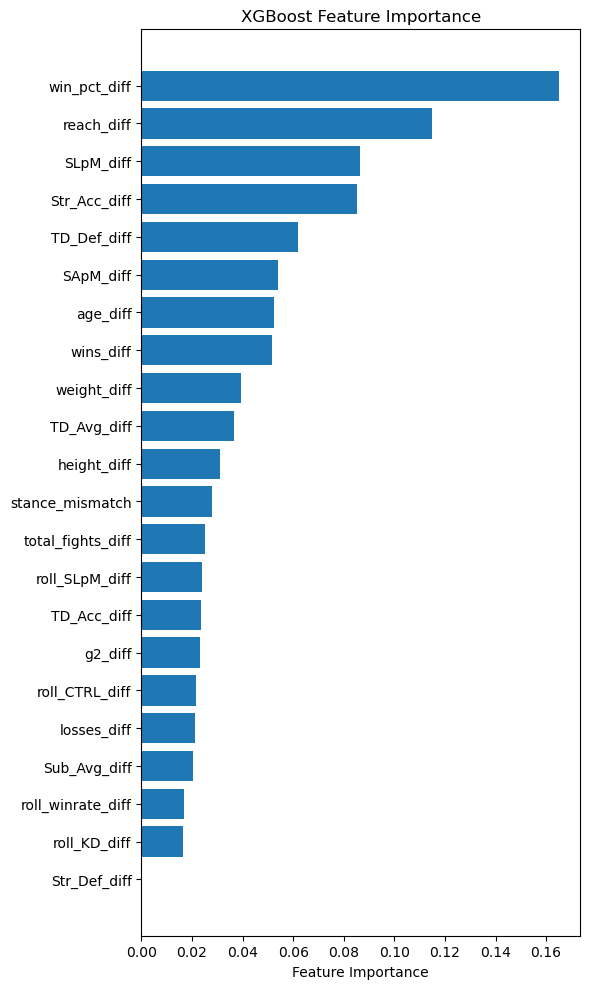

In [13]:
import matplotlib.pyplot as plt

importance = best_xgb.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(6, 10))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

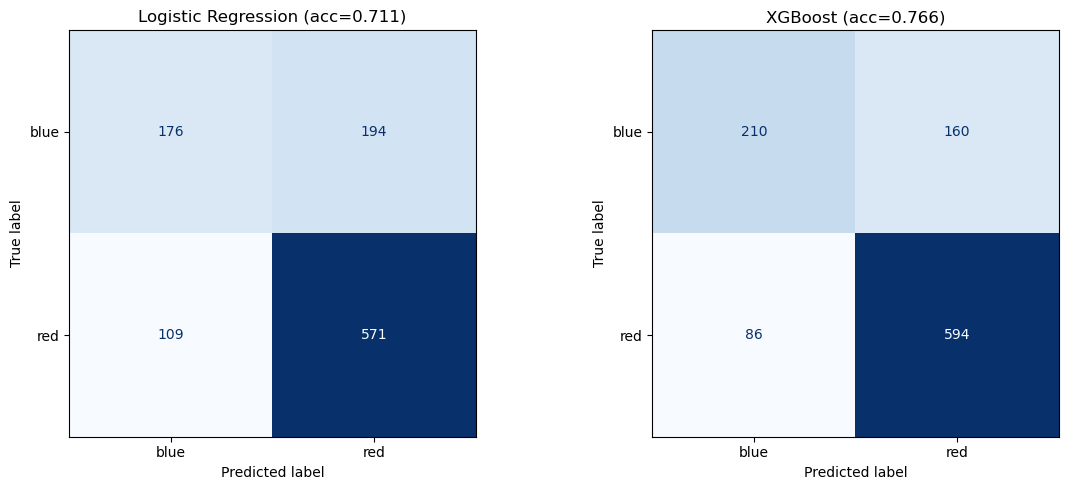

Logistic Regression confusion matrix:
 [[176 194]
 [109 571]]
XGBoost confusion matrix:
 [[210 160]
 [ 86 594]]


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# compute confusion matrices
cm_lr = confusion_matrix(y_test, pred_lr)
cm_xgb = confusion_matrix(y_test, pred_xgb)

# plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['blue', 'red'])
disp_lr.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title(f'Logistic Regression (acc={acc_lr:.3f})')

disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=['blue', 'red'])
disp_xgb.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title(f'XGBoost (acc={acc_xgb:.3f})')

plt.tight_layout()
plt.show()

# also print raw matrices
print("Logistic Regression confusion matrix:\n", cm_lr)
print("XGBoost confusion matrix:\n", cm_xgb)

In [15]:
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# ===============================================
#   FEATURE LISTS
# ===============================================
stats_cols = [
    "height","weight","reach","age",
    "SLpM","SApM","Str_Acc","Str_Def",
    "TD_Avg","TD_Acc","TD_Def","Sub_Avg",
    "wins","losses","total_fights","win_pct"
]

rolling_cols = ["roll_winrate", "roll_SLpM", "roll_CTRL", "roll_KD"]

# ===============================================
#   CLEAN FIGHTER ROW
# ===============================================
def get_fighter_vector(name):
    try:
        row = fighters_clean.loc[name].copy()
    except KeyError:
        raise ValueError(f"Fighter '{name}' not in dataset")

    pct_cols = ["Str_Acc","Str_Def","TD_Acc","TD_Def"]
    hw_cols = ["height","weight","reach"]

    for c in pct_cols + hw_cols:
        val = str(row[c])
        extracted = pd.to_numeric(
            pd.Series(val).str.extract(r"(\d+\.?\d*)")[0],
            errors="coerce"
        )
        row[c] = extracted.iloc[0] if not extracted.empty else 0.0

    # force numeric
    for c in stats_cols + rolling_cols + ["g2"]:
        if c in row:
            row[c] = pd.to_numeric(row[c], errors="coerce")

    return row.fillna(0)


# =============================================================
#   PREDICT USING THE MODEL (SHAP INCLUDED)
# =============================================================
def predict_fight(model, fighter_A, fighter_B):

    A = get_fighter_vector(fighter_A)
    B = get_fighter_vector(fighter_B)

    feat_dict = {}

    # -----------------------
    # 1. Stats diffs
    # -----------------------
    for col in stats_cols:
        feat_dict[f"{col}_diff"] = float(A[col] - B[col])

    # -----------------------
    # 2. Stance mismatch
    # -----------------------
    stance_A = fighters_clean.loc[fighter_A].get("stance")
    stance_B = fighters_clean.loc[fighter_B].get("stance")
    feat_dict["stance_mismatch"] = int(stance_A != stance_B)

    # -----------------------
    # 3. Rolling diffs
    # -----------------------
    for r in rolling_cols:
        feat_dict[f"{r}_diff"] = float(A.get(r, 0) - B.get(r, 0))

    # -----------------------
    # 4. Glicko-2 diff
    # -----------------------
    feat_dict["g2_diff"] = float(A.get("g2", 1500) - B.get("g2", 1500))

    # -----------------------
    # Build model input (EXACT ORDER)
    # -----------------------
    X = pd.DataFrame([feat_dict])[model.feature_names_in_]
    X_floats = X.fillna(0).astype(float)

    # -----------------------
    # SHAP Explanation
    # -----------------------
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_floats)

    shap.initjs()
    display(shap.force_plot(explainer.expected_value, shap_values[0], X_floats.iloc[0]))
    display(shap.bar_plot(shap_values[0], feature_names=X_floats.columns))

    # Print top 10 features
    sorted_vals = sorted(
        zip(shap_values[0], X_floats.columns),
        key=lambda x: abs(x[0]),
        reverse=True
    )
    print("\nTop 10 most influential features:")
    for val, col in sorted_vals[:10]:
        print(f"{col}: {val:+.4f}")

    # -----------------------
    # Probability prediction
    # -----------------------
    prob_A = float(model.predict_proba(X_floats)[0][1])
    prob_B = 1 - prob_A

    return {
        "fighter_A": fighter_A,
        "fighter_B": fighter_B,
        "prob_A_wins": prob_A,
        "prob_B_wins": prob_B,
        "predicted_winner": fighter_A if prob_A >= 0.5 else fighter_B,
        "model_input": X_floats.values[0],
        "feature_names": list(X_floats.columns),
        "features": feat_dict     # optional but useful
    }



# =============================================================
#   AUC-ROC EVALUATION
# =============================================================
def compute_auc(model, X_test, y_test):
    """
    Computes AUC-ROC using predicted probabilities.
    """
    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)
    print(f"\nAUC-ROC: {auc:.4f}")
    return auc


In [16]:
compute_auc(best_xgb, X_test, y_test)



AUC-ROC: 0.8456


0.8455961844197137

In [17]:
def simulate_fight_with_noise(model, fighter1, fighter2, n=5000, noise=0.05):

    base = predict_fight(model, fighter1, fighter2)
    X = base["model_input"].copy()
    feature_names = base["feature_names"]

    wins_f1 = 0

    # Features that we allow to fluctuate (performance-related)
    dynamic_features = [
        "SLpM_diff", "SApM_diff", "Str_Acc_diff", "Str_Def_diff",
        "TD_Avg_diff", "TD_Acc_diff", "TD_Def_diff",
        "Sub_Avg_diff",
        "win_pct_diff",
        "form_diff", "momentum_diff",  # if you have rolling stats
    ]
    
    # Indices of dynamic features
    dyn_idx = [i for i, f in enumerate(feature_names) if f in dynamic_features]

    for _ in range(n):

        X_sim = X.copy()

        # Inject noise ONLY in dynamic stats
        X_sim[dyn_idx] = X_sim[dyn_idx] * (1 + np.random.normal(0, noise, len(dyn_idx)))

        prob = model.predict_proba(X_sim.reshape(1, -1))[0][1]

        if prob > 0.5:
            wins_f1 += 1

    return wins_f1 / n


In [66]:
fighter1 = "Tatsuro Taira"
fighter2 = "Brandon Moreno"

def american_to_decimal(odds):
    """
    Convert American odds (e.g., -150, +200) to decimal odds.
    Returns a float.
    """
    odds = float(odds)

    if odds > 0:
        # Positive odds
        return 1 + (odds / 100)
    else:
        # Negative odds
        return 1 + (100 / abs(odds))


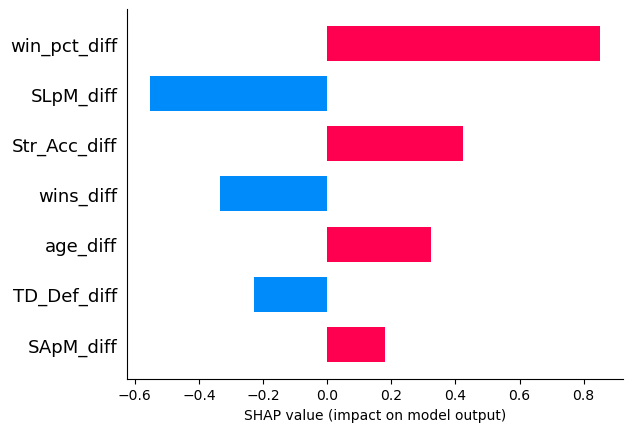

None


Top 10 most influential features:
win_pct_diff: +0.8524
SLpM_diff: -0.5541
Str_Acc_diff: +0.4246
wins_diff: -0.3352
age_diff: +0.3226
TD_Def_diff: -0.2293
SApM_diff: +0.1812
losses_diff: +0.1270
Sub_Avg_diff: +0.1076
g2_diff: +0.0820


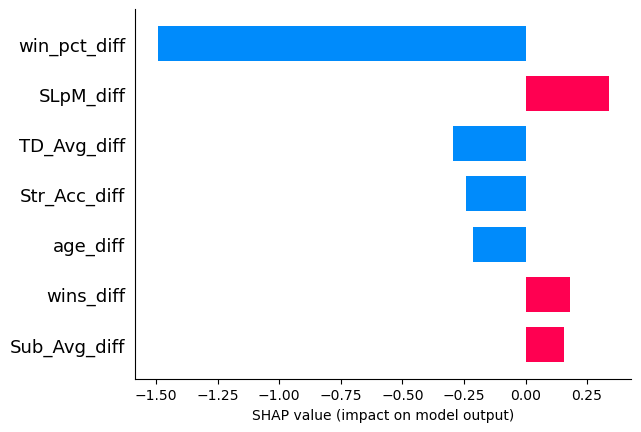

None


Top 10 most influential features:
win_pct_diff: -1.4936
SLpM_diff: +0.3377
TD_Avg_diff: -0.2926
Str_Acc_diff: -0.2402
age_diff: -0.2142
wins_diff: +0.1789
Sub_Avg_diff: +0.1582
TD_Def_diff: +0.1232
total_fights_diff: -0.1011
weight_diff: -0.0882

Tatsuro Taira:
  Win Probability: 0.782
  Odds: 1.7751937984496124
  EV: 1.171
  Kelly Fraction: 0.2506
  Suggested Bet ($): 250.64

Brandon Moreno:
  Win Probability: 0.218
  Odds: 2.0
  EV: -0.347
  Kelly Fraction: 0.0
  Suggested Bet ($): 0.0

👉 Bet on Tatsuro Taira with EV=1.171, amount=$250.64


In [ ]:
import pandas as pd

def compute_ev_and_kelly(prob, odds, bankroll=1000, kelly_fraction=0.5):
    b = odds - 1
    q = 1 - prob

    # Expected Value
    EV = prob * odds - (1 - prob)

    # Full Kelly formula
    kelly_full = (b * prob - q) / b if b > 0 else 0

    # Fractional Kelly
    kelly_adj = max(0, kelly_full) * kelly_fraction

    bet_size = kelly_adj * bankroll
    
    return EV, kelly_full, kelly_adj, bet_size


# Predict both ways
r1 = predict_fight(best_xgb, fighter1, fighter2)
r2 = predict_fight(best_xgb, fighter2, fighter1)

# Symmetric probabilities
p1 = r1["prob_A_wins"]
p2 = 1 - r2["prob_A_wins"]

avg_f1 = (p1 + p2) / 2
avg_f2 = 1 - avg_f1

# Odds
odds_f1 = american_to_decimal(-129)
odds_f2 = american_to_decimal(100) 

# Run EV + Kelly
EV1, kelly_full1, kelly1, bet1 = compute_ev_and_kelly(avg_f1, odds_f1)
EV2, kelly_full2, kelly2, bet2 = compute_ev_and_kelly(avg_f2, odds_f2)

# Print
print(f"\n{fighter1}:")
print("  Win Probability:", round(avg_f1, 3))
print("  Odds:", odds_f1)
print("  EV:", round(EV1, 3))
print("  Kelly Fraction:", round(kelly1, 4))
print("  Suggested Bet ($):", round(bet1, 2))

print(f"\n{fighter2}:")
print("  Win Probability:", round(avg_f2, 3))
print("  Odds:", odds_f2)
print("  EV:", round(EV2, 3))
print("  Kelly Fraction:", round(kelly2, 4))
print("  Suggested Bet ($):", round(bet2, 2))


# DECISION RULES
min_edge = 0.04
min_kelly = 0.01
min_bet_amount = 100

def edge(prob, odds):
    return prob - (1/odds)

edge1 = edge(avg_f1, odds_f1)
edge2 = edge(avg_f2, odds_f2)

# Determine final bet
bet_candidate = None
if EV1 > 0 and edge1 >= min_edge and kelly1 >= min_kelly and bet1 >= min_bet_amount:
    bet_candidate = (fighter1, EV1, bet1)

if EV2 > 0 and edge2 >= min_edge and kelly2 >= min_kelly and bet2 >= min_bet_amount:
    if bet_candidate is None or EV2 > bet_candidate[1]:
        bet_candidate = (fighter2, EV2, bet2)

if bet_candidate:
    print(f"\n Bet on {bet_candidate[0]} with EV={bet_candidate[1]:.3f}, amount=${bet_candidate[2]:.2f}")
else:
    print("\n No safe +EV bet.")


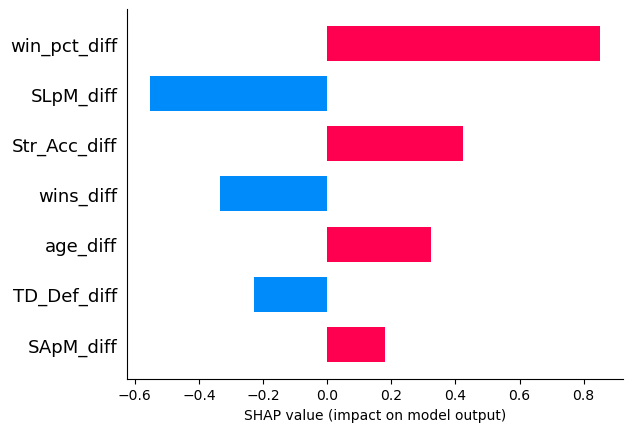

None


Top 10 most influential features:
win_pct_diff: +0.8524
SLpM_diff: -0.5541
Str_Acc_diff: +0.4246
wins_diff: -0.3352
age_diff: +0.3226
TD_Def_diff: -0.2293
SApM_diff: +0.1812
losses_diff: +0.1270
Sub_Avg_diff: +0.1076
g2_diff: +0.0820
Tatsuro Taira simulated win probability: 1.000
Brandon Moreno simulated win probability: 0.000


In [68]:

sim = simulate_fight_with_noise(best_xgb, fighter1, fighter2, n=10000, noise=0.05)

print(f"{fighter1} simulated win probability: {sim:.3f}")
print(f"{fighter2} simulated win probability: {1 - sim:.3f}")